In [1]:
import sys
import os

# Add the src folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))

import numpy as np
import matplotlib.pyplot as plt

from mesh import *
from geometry import *
import material
import cross_section
import beam_element
import structure
import solver

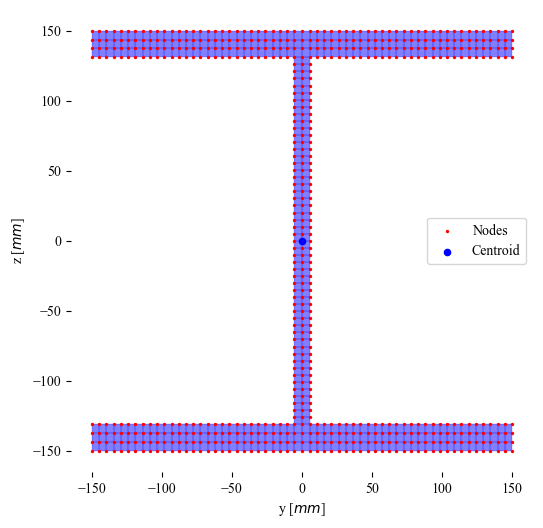

In [2]:
HEB_300 = H_beam(web_width     =  11.0,
                 web_height    = 262.0,
                 flange_width  = 300.0,
                 flange_height =  19.0)
beam = Mesh(HEB_300, mesh_type="quadrilateral", mesh_size=5)
beam.plot()


In [3]:
struc_6  = structure.Cantilever(beam        = beam, 
								length      = 1000, 
								load_DOFs   = [6+2],
								nodal_loads = [1],
								number_of_sections_per_elemnt = 10)

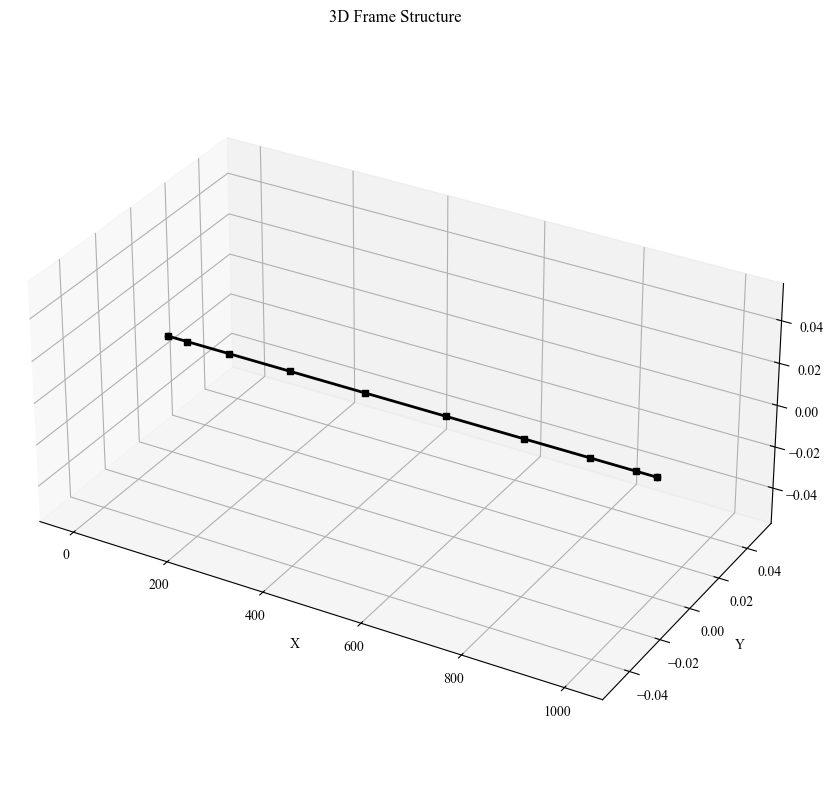

In [4]:
lin_solver = solver.Linear(struc_6)
lin_solver.plot_initial_structure()

In [5]:
non_linear_solver_6  = solver.Nonlinear(struc_6, 
									    constraint     ="Displacement", 
									    controlled_DOF = 8)

In [6]:
increments = np.zeros(400)
increments.fill(0.05)

#from contextlib import redirect_stdout
#with open(os.devnull, 'w') as f, redirect_stdout(f):
u_history_6 , lambda_history_6, section_forces, section_strains  = non_linear_solver_6.solve(increments)

  0%|          | 0/400 [00:00<?, ?it/s]

----------------------------------------------
Load step 1 of 400
   Attempt  1
      NR Iteration  0
         Beam Element  1
            Element iteration  0
      Residuals Norm  9.313296800157313e-10
NR Converged!
----------------------------------------------
Load step 2 of 400
   Attempt  1
      NR Iteration  0
         Beam Element  1
            Element iteration  0
      Residuals Norm  9.313509958912413e-10
NR Converged!
----------------------------------------------
Load step 3 of 400
   Attempt  1
      NR Iteration  0
         Beam Element  1
            Element iteration  0
      Residuals Norm  9.313509958912413e-10
NR Converged!
----------------------------------------------
Load step 4 of 400
   Attempt  1
      NR Iteration  0
         Beam Element  1
            Element iteration  0
      Residuals Norm  9.313509958912413e-10
NR Converged!
----------------------------------------------
Load step 5 of 400
   Attempt  1
      NR Iteration  0
         Beam Element  1
 

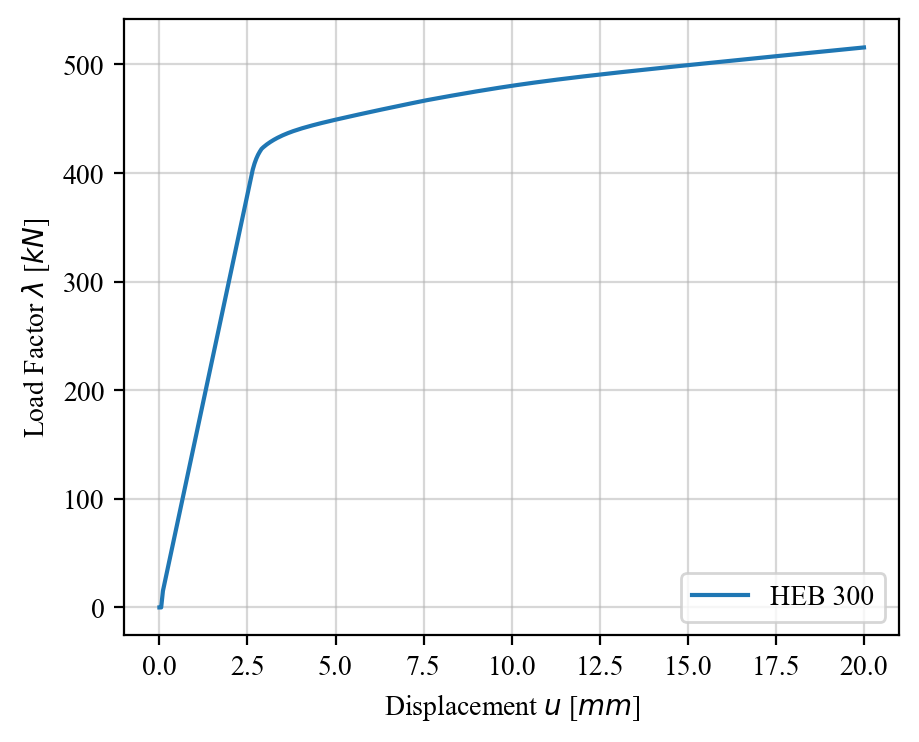

In [190]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Main figure and axes
fig, ax = plt.subplots(figsize=(5, 4))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 200

ls=["dashdot", (0, (3, 5, 1, 5, 1, 5)),"dashed", "dotted","-"]

ax.plot(u_history_6[:,6+2], lambda_history_6/1000,   label="HEB 300", ls="-")
ax.set_xlabel("Displacement $u$ [$mm$]")
ax.set_ylabel("Load Factor $\\lambda$ [$kN$]")
ax.legend(loc="lower right")
ax.grid(alpha=0.5)

plt.show()

In [184]:
import numpy as np
import matplotlib.pyplot as plt


def plot_moments(step):
	# Example input: replace with your actual values
	x = np.array((non_linear_solver_6.structure.beam_elements[0].gauss_points + 1)/2 * 1000)  # positions along the cantilever (in meters)
	kappa_50 = np.array(section_strains[50,0,:,0])  # curvature at each x (in 1/m)
	kappa_100 = np.array(section_strains[100,0,:,0])  # curvature at each x (in 1/m)
	kappa_399 = np.array(section_strains[399,0,:,0])  # curvature at each x (in 1/m)

	# First integration: slope (rotation)
	theta_50 = np.zeros_like(x)
	theta_100 = np.zeros_like(x)
	theta_399 = np.zeros_like(x)
	for i in range(1, len(x)):
		dx = x[i] - x[i - 1]
		theta_50[i] = theta_50[i - 1] + 0.5 * (kappa_50[i] + kappa_50[i - 1]) * dx
		theta_100[i] = theta_100[i - 1] + 0.5 * (kappa_100[i] + kappa_100[i - 1]) * dx
		theta_399[i] = theta_399[i - 1] + 0.5 * (kappa_399[i] + kappa_399[i - 1]) * dx

	# Second integration: vertical deflection
	v_50 = np.zeros_like(x)
	v_100 = np.zeros_like(x)
	v_399 = np.zeros_like(x)
	for i in range(1, len(x)):
		dx = x[i] - x[i - 1]
		v_50[i] = v_50[i - 1] + 0.5 * (theta_50[i] + theta_50[i - 1]) * dx
		v_100[i] = v_100[i - 1] + 0.5 * (theta_100[i] + theta_100[i - 1]) * dx
		v_399[i] = v_399[i - 1] + 0.5 * (theta_399[i] + theta_399[i - 1]) * dx


	fig, (curv, rot, defl, moment) = plt.subplots(1,4, gridspec_kw={'width_ratios': [1, 1, 1, 1]}, figsize=(12, 5), dpi=200)


	# Optional: plot the results
	curv.plot(kappa_50, x, zorder=4, color="C0", label="388 kN")
	curv.plot(kappa_100, x, zorder=3, color="C1", label="449 kN")
	curv.plot(kappa_399, x, zorder=2, color="C2", label="515 kN")
	curv.plot([0,0,0,0,0,0,0,0,0,0], x, zorder=5, color="k", marker="s", markersize=2)
	curv.fill_betweenx(x, kappa_50, zorder=4, color="C0", alpha=0.2)
	curv.fill_betweenx(x, kappa_100, zorder=3, color="C1", alpha=0.2)
	curv.fill_betweenx(x, kappa_399, zorder=2, color="C2", alpha=0.2)
	curv.set_xlabel("Curvature $\\kappa$ [$1/m$]")
	curv.set_ylabel("length $x$ [$m$]")
	curv.legend(loc="upper right")
	curv.set_xlim(-max(kappa_399)*1.2, max(kappa_399)*1.2)
	curv.grid()

	rot.plot(theta_50, x, zorder=4, color="C0")
	rot.plot(theta_100, x, zorder=3, color="C1")
	rot.plot(theta_399, x, zorder=2, color="C2")
	rot.fill_betweenx(x, theta_50, zorder=4, alpha=0.2, color="C0")
	rot.fill_betweenx(x, theta_100, zorder=3, alpha=0.2, color="C1")
	rot.fill_betweenx(x, theta_399, zorder=2, alpha=0.2, color="C2")
	rot.plot([0,0,0,0,0,0,0,0,0,0], x, zorder=5, color="k", marker="s", markersize=2)
	rot.set_xlabel("Rotation $\\theta$ [$rad$]")
	rot.set_xlim(-max(theta_399)*1.2, max(theta_399)*1.2)
	rot.grid()

	defl.plot(v_50, x, zorder=4, color="C0")
	defl.plot(v_100, x, zorder=3, color="C1")
	defl.plot(v_399, x, zorder=2, color="C2")
	defl.fill_betweenx(x, v_50, zorder=4, alpha=0.2, color="C0")
	defl.fill_betweenx(x, v_100, zorder=3, alpha=0.2, color="C1")
	defl.fill_betweenx(x, v_399, zorder=2, alpha=0.2, color="C2")
	defl.plot([0,0,0,0,0,0,0,0,0,0], x, zorder=5, color="k", marker="s", markersize=2)
	defl.set_xlabel("Displacement $u$ [$mm$]")
	defl.set_xlim(-max(v_399)*1.2, max(v_399)*1.2)
	defl.grid()

	My_50 = section_forces[50,0,:,0] / 1000 / 1000
	My_100 = section_forces[100,0,:,0] / 1000 / 1000
	My_399 = section_forces[399,0,:,0] / 1000 / 1000
	moment.plot(My_50, x, zorder=4, color="C0")
	moment.plot(My_100, x, zorder=3, color="C1")
	moment.plot(My_399, x, zorder=2, color="C2")
	moment.fill_between(My_50, x, zorder=4, alpha=0.2, color="C0")
	moment.fill_between(My_100, x, zorder=3, alpha=0.2, color="C1")
	moment.fill_between(My_399, x, zorder=2, alpha=0.2, color="C2")
	moment.plot([0,0,0,0,0,0,0,0,0,0], x, zorder=5, color="k", marker="s", markersize=2)
	moment.set_xlabel("Bending Moment $M_y$ [$kNm$]")
	moment.set_xlim(-max(My)*1.2, max(My)*1.2)
	moment.grid(zorder=0)

	plt.tight_layout()

In [138]:
import numpy as np
import matplotlib.pyplot as plt


def plot_moments(step):
	# Example input: replace with your actual values
	x = np.array((non_linear_solver_6.structure.beam_elements[0].gauss_points + 1)/2 * 1000)  # positions along the cantilever (in meters)
	kappa = np.array(section_strains[step,0,:,0])  # curvature at each x (in 1/m)

	# First integration: slope (rotation)
	theta = np.zeros_like(x)
	for i in range(1, len(x)):
		dx = x[i] - x[i - 1]
		theta[i] = theta[i - 1] + 0.5 * (kappa[i] + kappa[i - 1]) * dx

	# Second integration: vertical deflection
	v = np.zeros_like(x)
	for i in range(1, len(x)):
		dx = x[i] - x[i - 1]
		v[i] = v[i - 1] + 0.5 * (theta[i] + theta[i - 1]) * dx


	fig, (plot, curv, rot, defl, moment) = plt.subplots(1,5, gridspec_kw={'width_ratios': [2, 1, 1, 1, 1]}, figsize=(15, 4), dpi=200)

	plot.plot(u_history_6[:,6+2], lambda_history_6/1000,)
	plot.scatter(u_history_6[:,6+2][step], lambda_history_6[step]/1000, color = "red", zorder=3)
	plot.set_xlabel("Displacement $u$ [$mm$]")
	plot.set_ylabel("Load Factor $\\lambda$ [$kN$]")
	plot.grid()


	# Optional: plot the results
	curv.plot(kappa, x, zorder=2, color="C0")
	curv.fill_betweenx(x, kappa, zorder=2, color="C0", alpha=0.5)
	curv.set_xlabel("Curvature $\\kappa$ [$1/m$]")
	curv.set_xlim(-max(kappa)*1.2, max(kappa)*1.2)
	curv.grid()

	rot.plot(theta, x, zorder=2, color="C1")
	rot.fill_betweenx(x, theta, zorder=2, alpha=0.5, color="C1")
	rot.set_xlabel("Rotation $\\theta$ [$rad$]")
	rot.set_xlim(-max(theta)*1.2, max(theta)*1.2)
	rot.grid()

	defl.plot(v, x, zorder=2, color="C2")
	defl.fill_betweenx(x, v, zorder=2, alpha=0.5, color="C2")
	defl.set_xlabel("Displacement $u$ [$mm$]")
	defl.set_xlim(-max(v)*1.2, max(v)*1.2)
	defl.grid()

	My = section_forces[step,0,:,0] / 1000 / 1000
	moment.plot(My, x, zorder=2, color="C3")
	moment.fill_between(My, x, zorder=2, alpha=0.5, color="C3")
	moment.set_xlabel("Bending Moment $M_y$ [$kNm$]")
	moment.set_xlim(-max(My)*1.2, max(My)*1.2)
	moment.grid(zorder=0)

	plt.tight_layout()

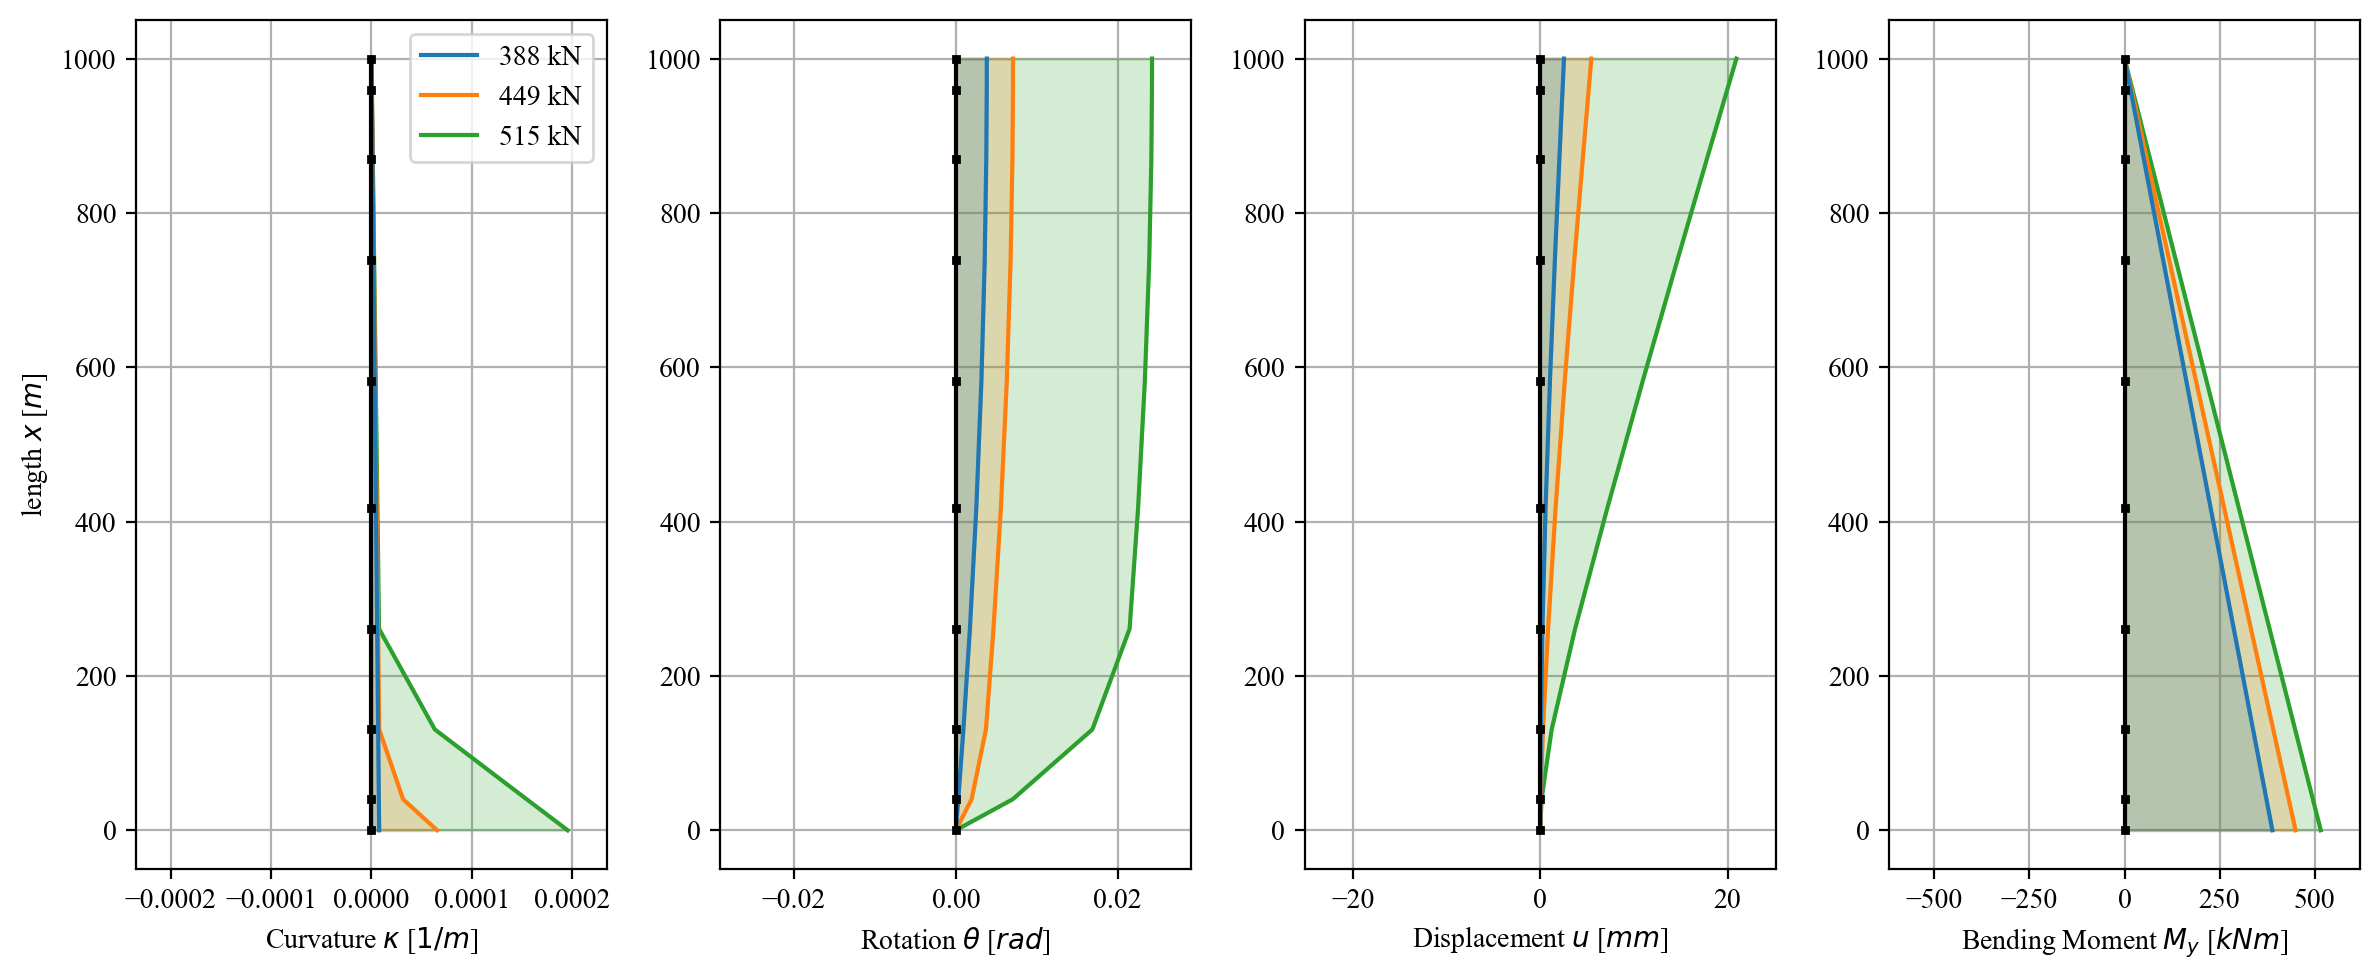

In [185]:
plot_moments(50)

In [142]:
import os
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np

steps = np.linspace(0, 399, 200)

# Create a folder to store frames
os.makedirs("frames", exist_ok=True)

for i, step in enumerate(steps):
    plot_moments(int(step))
    plt.savefig(f"frames/frame_{i:03d}.png")
    plt.close()

In [143]:
# Create GIF
from PIL import Image

os.makedirs("images", exist_ok=True)
images = [Image.open(f"frames/frame_{i:03d}.png") for i in range(len(steps))]
images[0].save("images/HEB_300_Cantilever.gif", save_all=True, append_images=images[1:], duration=150, loop=0)